<a href="https://colab.research.google.com/github/abdalrahmenyousifMohamed/Master-TensorFlow/blob/main/5_1_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# State-of-the-art in deep learning: Transformers

Transformers are the latest addition to the deep learning portfolio. Transformer networks started from the natural language processing domain and has permeated to other areas like computer vision. This was introduced in the paper [Attention is all you need](https://arxiv.org/pdf/1706.03762.pdf) by Vaswani et. al. In this chapter, we are going to look at various technical details of how to implement a Transformer ourselves. The Transformer has two main parts.

* Encoder
* Decoder

Both the encoder and the decoder has multiple layers in it, and each layer consists of following types of sub layers.

* Self-attention layer - This layer allows to pay attention to other inputs words in the sequence while processing a given input word. For example if the model is processing the word "it" from the sentence "I kicked the ball and it disappeared", this layer can pay attention the word "ball" while processing the word "it". This ability is quite important when it comes to natural language related tasks.
* Fully connected layer - This adds depth to the model, allowing the model to learn more and more high level features.

In this notebook you will learn,

* The computations used in the self-attention and fully-connected sub layers
* How to use the sub-classing API to create custom Self-Attention and Fully Connected layers
* Use TensorFlow opeartions to define input masks
* Define the Encoder and Decoder as layers


<table align="left">
    <td>
        <a target="_blank" href="https://colab.research.google.com/github/thushv89/manning_tf2_in_action/blob/master/Ch05-Fundamentals-of-Transformers/5.1.Transformer.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
    </td>
</table>


## Importing necessary libraries

In [10]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import math

## Defining the inputs and variables

Here we define an input sequence (having 7 timesteps) and the respective variables that will be in a self-attention layer. The input to the model is a batch of sentences, and each sentence is a sequence of words, and each word is represented as a vector (e.g. word embeddings). In summary, the input has following dimensions.

* Batch dimension (1) - In our example, a batch will have a single sentence
* Time dimension (7) - In our example, the sentence has 7 words
* Feature dimension (512) - In our example, each word is represented by a 512 elements long word vector

The weights are of size $n \times n$, where $n$ is the feature dimensionality of the input to that layer. This means that during the computations, the weight matrix takes a $b \times t \times n$ input and prodicues a $b \times t \times n$.

In [2]:
# Section 5.2

import tensorflow as tf
import numpy as np

n_seq = 7 # Sequence length

# Defining the input
x = tf.constant(np.random.normal(size=(1,n_seq,512)), dtype='float32')

# Query, Key and Value matrices
Wq = tf.Variable(np.random.normal(size=(512,512)), dtype='float32')
Wk = tf.Variable(np.random.normal(size=(512,512)), dtype='float32')
Wv = tf.Variable(np.random.normal(size=(512,512)), dtype='float32')

# Printing the shapes of the data
print('x.shape={}'.format(x.shape))
print('Wq.shape={}'.format(Wq.shape))
print('Wk.shape={}'.format(Wk.shape))
print('Wv.shape={}'.format(Wv.shape))

x.shape=(1, 7, 512)
Wq.shape=(512, 512)
Wk.shape=(512, 512)
Wv.shape=(512, 512)


In [4]:
import tensorflow as tf
import numpy as np

n_seq = 7 # Sequence length

# Defining the input
x = tf.constant(np.random.normal(size=(1,n_seq,512)) , dtype='float32')

# Query , key , value matrices
Wq = tf.Variable(np.random.normal(size=(512,512)) , dtype='float32')
Wk = tf.Variable(np.random.normal(size=(512,512)) , dtype='float32')
Wv = tf.Variable(np.random.normal(size=(512,512)) , dtype='float32')

print('x.shape={}'.format(x.shape))
print('Wq.shape={}'.format(Wq.shape))
print('Wv.shape={}'.format(Wv.shape))
print('WK.shape={}'.format(Wk.shape))

x.shape=(1, 7, 512)
Wq.shape=(512, 512)
Wv.shape=(512, 512)
WK.shape=(512, 512)


## Defining the SelfAttention layer

Here we are going to define the self-attention mechanism encapsulated in a Keras layer.

In [16]:
# Section 5.2
# Code listing 5.1

import tensorflow as tf

class SelfAttentionLayer(layers.Layer):
    """ Defines the computations in the self attention layer """
    def __init__(self, d):
        super(SelfAttentionLayer, self).__init__()
        # Feature dimensionality of the output
        self.d = d

    def build(self, input_shape):
        # Query weight matrix
        self.Wq = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
        # Key weight matrix
        self.Wk = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
        # Value weight matrix
        self.Wv = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )

    def call(self, q_x, k_x, v_x):
        # Computing query, key and value
        q = tf.matmul(q_x,self.Wq)
        k = tf.matmul(k_x,self.Wk)
        v = tf.matmul(v_x,self.Wv)

        # Computing the probability matrix
        p = tf.nn.softmax(tf.matmul(q, k, transpose_b=True)/math.sqrt(self.d))
        p = tf.squeeze(p)

        # Computing the final output
        h = tf.matmul(p, v)
        return h,p

# Creating a dummy self attention layer
layer = SelfAttentionLayer(512)
# Getting the output
h, p = layer(x, x, x)
print(h.shape)

(1, 7, 512)


## Using the Self-Attention in a Multi-head Attention Layer

In the Transformer network found in the original paper, the self-attention layers are found as multi-head attention layers. This means each layer has multiple smaller attention layers. This enables the model to learn more robust features than when having a single big attention layer.

In [17]:
# Defining an array of SelfAttentionLayer objects forming a multi-head attention layer
multi_attn_head = [SelfAttentionLayer(64) for i in range(8)]
outputs = [head(x, x, x)[0] for head in multi_attn_head]

# Concatting the individual outputs to a single output
outputs = tf.concat(outputs, axis=-1)
print(outputs.shape)

(1, 7, 512)


## Defining a SelfAttention layer with Masking Capability

The decoder model uses a special type of attention layer. This attention layer masks any words ahead of the current word being processed. This in turn helps to avoid the decoder from seeing words it shouldn't during the training process.

In [27]:
# Section 5.2
# Code listing 5.2
import tensorflow as tf

class SelfAttentionLayer(layers.Layer):
    """ Defines the computations in the self attention layer """

    def __init__(self, d):
        super(SelfAttentionLayer, self).__init__()
        # Feature dimensionality of the output
        self.d = d

    def build(self, input_shape):
        # Query weight matrix
        self.Wq = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
        # Key weight matrix
        self.Wk = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
        # Value weight matrix
        self.Wv = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )

    def call(self, q_x, k_x, v_x, mask=None):
        # Computing query, key and value
        q = tf.matmul(q_x,self.Wq) #[None, t, d]
        k = tf.matmul(k_x,self.Wk) #[None, t, d]
        v = tf.matmul(v_x,self.Wv) #[None, t, d]

        # Computing the probability matrix
        p = tf.matmul(q, k, transpose_b=True)/math.sqrt(self.d) # [None, t, t]

        if mask is None:
            p = tf.nn.softmax(p)
        else:
            # Creating the mask
            p += mask * -1e9
            p = tf.nn.softmax(p)

        # Computing the final output
        h = tf.matmul(p, v) # [None, t, t] . [None, t, d] => [None, t, d]
        return h,p

layer = SelfAttentionLayer(512)
mask = 1 - tf.linalg.band_part(tf.ones((7, 7)), -1, 0)
h, p = layer(x, x, x, mask)
print(h.shape)

(1, 7, 512)


In [26]:
tf.ones((7, 7))

<tf.Tensor: shape=(7, 7), dtype=float32, numpy=
array([[1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

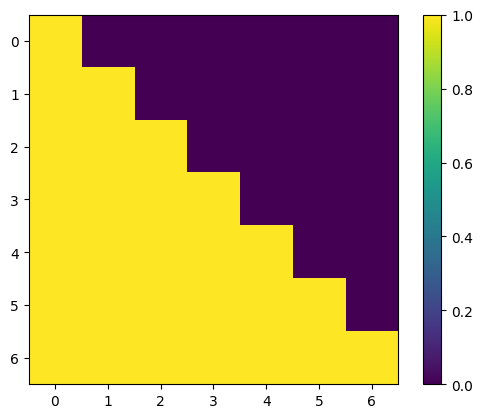

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

# Create a 7x7 matrix with ones
matrix = np.ones((7, 7))

# Extract the lower triangular band
triangular_matrix = tf.linalg.band_part(tf.ones((7, 7)), -1, 0)

# Color the upper triangular part with red
matrix[triangular_matrix == 0] = 0.0  # Set upper triangular elements to 0

# Create a heatmap
plt.imshow(matrix, cmap='viridis')
plt.colorbar()
plt.show()


In [23]:
tf.linalg.band_part(tf.ones((7, 7)), -1, 0)

<tf.Tensor: shape=(7, 7), dtype=float32, numpy=
array([[1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 0., 0., 0., 0.],
       [1., 1., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 1., 1., 1., 0., 0.],
       [1., 1., 1., 1., 1., 1., 0.],
       [1., 1., 1., 1., 1., 1., 1.]], dtype=float32)>

## Defining a Mask using TensorFlow

Let's now define an example mask in TensorFlow. As we have defined an input sequence having 7 steps, let's define a mask for 7 steps.

In [35]:
multi_attn_head = [SelfAttentionLayer(64) for i in range(8)]
outputs = [head(x, x, x)[0] for head in multi_attn_head]

In [43]:
import tensorflow as tf

# Create two example tensors with compatible shapes
tensor1 = tf.constant([[1, 2], [3, 4]])
tensor2 = tf.constant([[5, 6],[8, 9]])
print(tensor1)
print(tensor2)
# Expand the dimensions of tensor2 to make it compatible for concatenation

# Concatenate tensors along the last dimension (axis=-1)
concatenated_tensor = tf.concat([tensor1, tensor2], axis=-1)

# Print the concatenated tensor
print(concatenated_tensor)


tf.Tensor(
[[1 2]
 [3 4]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[5 6]
 [8 9]], shape=(2, 2), dtype=int32)
tf.Tensor(
[[1 2 5 6]
 [3 4 8 9]], shape=(2, 4), dtype=int32)


In [44]:
outputs = tf.concat(outputs, axis=-1)
print(outputs.shape)


(1, 7, 512)


## Defining the Fully-Connected Layer

Now let's define the fully-connected sublayer found in the Transformer networks.

In [45]:
# Section 5.2
# Code listing 5.3
import tensorflow as tf

class FCLayer(layers.Layer):
    """ The computations of a fully connected sublayer """
    def __init__(self, d1, d2):
        super(FCLayer, self).__init__()
        # Dimensionality of the first hidden layer
        self.d1 = d1
        # Dimensionality of the second hidden layer
        self.d2 = d2

    def build(self, input_shape):
        # First layer's weights and biases
        self.W1 = self.add_weight(
            shape=(input_shape[-1], self.d1), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
        self.b1 = self.add_weight(
            shape=(self.d1,), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
        # Second layer's weights and biases
        self.W2 = self.add_weight(
            shape=(self.d1, self.d2), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
        self.b2 = self.add_weight(
            shape=(self.d2,), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )

    def call(self, x):
        # Computing the first fully connected output
        ff1 = tf.nn.relu(tf.matmul(x,self.W1)+self.b1)
        # Computing the second fully connected output
        # Note that the second layer doesn't use an activation
        ff2 = tf.matmul(ff1, self.W2)+self.b2
        return ff2

# Creating a dummy fully connected layer
ff = FCLayer(2048, 512)(h)
print(ff.shape)

(1, 7, 512)


## Defining the Encoder Layer and the Decoder Layer

With all the low-level details ironed out, let's define the encoder and decoder layers.

In [46]:
# Section 5.2
# Code listing 5.5

import tensorflow as tf

class EncoderLayer(layers.Layer):
    """ The Encoder layer """

    def __init__(self, d, n_heads):
        super(EncoderLayer, self).__init__()
        # Feature dimensionality
        self.d = d
        # Dimensionality of a head
        self.d_head = int(d/n_heads)
        # Number of heads
        self.n_heads = n_heads
        # Actual attention heads
        self.attn_heads = [SelfAttentionLayer(self.d_head) for i in range(self.n_heads)]
        # Fully connected layer
        self.fc_layer = FCLayer(2048, self.d)

    def call(self, x):

        def compute_multihead_output(x):
            """ Computing the multi head attention output"""
            outputs = [head(x, x, x)[0] for head in self.attn_heads]
            outputs = tf.concat(outputs, axis=-1)
            return outputs

        # Multi head attention layer output
        h1 = compute_multihead_output(x)
        # Fully connected layer output
        y = self.fc_layer(h1)

        return y

In [47]:
# Code listing 5.6
class DecoderLayer(layers.Layer):
    """ The decoder layer """
    def __init__(self, d, n_heads):
        super(DecoderLayer, self).__init__()
        # Feature dimensionality
        self.d = d
        # Dimensionality of a single head
        self.d_head = int(d/n_heads)
        # Actual self attention heads (decoder inputs)
        self.dec_attn_heads = [SelfAttentionLayer(self.d_head) for i in range(n_heads)]
        # Actual self attention heads (encoder outputs)
        self.attn_heads = [SelfAttentionLayer(self.d_head) for i in range(n_heads)]
        # Fully connected layer
        self.fc_layer = FCLayer(2048, self.d)

    def call(self, de_x, en_x, mask=None):

        def compute_multihead_output(attn_heads, de_x, en_x, mask=None):
            """ Computing the multi head attention output"""
            outputs = [head(en_x, en_x, de_x, mask)[0] for head in attn_heads]
            outputs = tf.concat(outputs, axis=-1)
            return outputs

        # Multi head attention layer output (from decoder inputs)
        h1 = compute_multihead_output(self.dec_attn_heads, de_x, de_x, mask)
        # Multi head attention layer output (from encoder outputs)
        h2 = compute_multihead_output(self.attn_heads, h1, en_x)
        y = self.fc_layer(h2)
        return y

## Defining a Simple Transformer Network

In [48]:
# Section 5.2
# Code listing 5.7

import tensorflow as tf

# Defining some hyperparameters
n_steps = 25 # Sequence length
n_en_vocab = 300 # Encoder's vocabulary size
n_de_vocab = 400 # Decoder's vocabulary size
n_heads = 8 # Number of attention heads
d = 512 # The feature dimensionality of each layer

# Look-ahead mask
mask = 1 - tf.linalg.band_part(tf.ones((n_steps, n_steps)), -1, 0)

# Encoder input layer
en_inp = layers.Input(shape=(n_steps,))
# Encoder input embedddings
en_emb = layers.Embedding(n_en_vocab, 512, input_length=n_steps)(en_inp)

# Two encoder layers
en_out1 = EncoderLayer(d, n_heads)(en_emb)
en_out2 = EncoderLayer(d, n_heads)(en_out1)

# Decoder input layer
de_inp = layers.Input(shape=(n_steps,))
# Decoder input embeddings
de_emb = layers.Embedding(n_de_vocab, 512, input_length=n_steps)(de_inp)

# Two decoder layers
de_out1 = DecoderLayer(d, n_heads)(de_emb, en_out2, mask)
de_out2 = DecoderLayer(d, n_heads)(de_out1, en_out2, mask)

# Final output layer
de_pred = layers.Dense(n_de_vocab, activation='softmax')(de_out2)

# Defining the model
transformer = models.Model(inputs=[en_inp, de_inp], outputs=de_pred, name='MinTransformer')
# Compiling the model
transformer.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
transformer.summary()

Model: "MinTransformer"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 25, 512)      153600      ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 encoder_layer (EncoderLayer)   (None, 25, 512)      2886144     ['embedding[0][0]']              
                                                                                     